#IT0425 - Introducción a la Inteligencia Artificial

### Otoño 2023

### IT0425_Lab_2.9

**Profesor Enrique Naredo García**

<font size = 2>
©️ Todos los derechos reservados. All rights reserved.

*Nota: El presente documento es una herramienta diseñada única y exclusivamente para los estudiantes de la asignatura arriba mencionada. Se recuerda no compartir esta información fuera de los integrantes registrados en este curso. La reproducción total o parcial de este documento requiere autorización por escrito del titular del copyright.*
</font>

#Clasificación de SPAM

El concepto de "[spam](http://archive.ics.uci.edu/dataset/94/spambase)" es diverso: anuncios de productos/sitios web, esquemas para ganar dinero rápidamente, cartas en cadena, pornografía, etc.

* El conjunto de datos es obtenido de la página de UCI Machine Learning Repository.
* La colección de correos electrónicos no deseados provino del administrador de correo (UCI) y de personas que habían enviado spam.
* La tarea de clasificación de este conjunto de datos es determinar si un correo electrónico determinado es spam o no.
* Para más información sobre spam: Cranor, Lorrie F., LaMacchia, Brian A. Spam!, Communications of the ACM, 41(8):74-83, 1998.
* El rendimiento típico es de aproximadamente un 7 % de error de clasificación errónea.
* Los falsos positivos (marcar el correo bueno como spam) son muy indeseables.
* Si insistimos en cero falsos positivos en el conjunto de entrenamiento/prueba, entre el 20 y el 25 % del spam pasó por el filtro.
* Consulta también el Informe técnico exclusivo interno de Hewlett-Packard. Versión externa próximamente.

La colección de [spam](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset) de SMS es un conjunto de mensajes SMS etiquetados que se han recopilado para la investigación de spam de SMS.
* Contiene un conjunto de mensajes SMS en inglés de 5.574 mensajes, etiquetados según sean ham (legítimos) o spam.
* The files contain one message per line.
* Cada línea está compuesta por dos columnas: v1 contiene la etiqueta (ham o spam) y v2 contiene el texto sin formato.

## DEAP
[DEAP](https://deap.readthedocs.io/en/master/index.html) es un novedoso marco de cálculo evolutivo para la creación rápida de prototipos y pruebas de ideas.
* Busca hacer explícitos los algoritmos y transparentes las estructuras de datos.
* Funciona en perfecta armonía con mecanismos de paralelización como el multiprocesamiento y SCOOP.
* La siguiente documentación presenta los conceptos clave y muchas características para construir sus propias evoluciones.

In [1]:
!pip install deap

In [2]:
# librerías DEAP
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [3]:
# librerías estándar
import random
import operator
import csv
import itertools
import numpy
from functools import partial

In [4]:
# montar drive
from google.colab import drive
drive.mount('/content/drive/');

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
# obtener datos
with open("/content/drive/MyDrive/Datasets/spambase.csv") as spambase:
    spamReader = csv.reader(spambase)
    spam = list(list(float(elem) for elem in row) for row in spamReader)

In [6]:
# define un conjunto de (funciones) primitivas para GP
pset = gp.PrimitiveSetTyped("MAIN", itertools.repeat(float, 57), bool, "IN")

In [7]:
# agrega operadores Booleanos
pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)


In [9]:
# agrega operaciones aritméticas
pset.addPrimitive(operator.add, [float,float], float)
pset.addPrimitive(operator.sub, [float,float], float)
pset.addPrimitive(operator.mul, [float,float], float)

In [8]:
# define una division protegida
def protectedDiv(left, right):
    try: return left / right
    except ZeroDivisionError: return 1

In [ ]:
# agrega la division protegida
pset.addPrimitive(protectedDiv, [float,float], float)

In [ ]:
# agrega operadores de comparación
pset.addPrimitive(operator.lt, [float, float], bool)
pset.addPrimitive(operator.eq, [float, float], bool)

In [10]:
# define una función if-then-else
def if_then_else(input, output1, output2):
    if input: return output1
    else: return output2

In [11]:
# agrega la función if-then-else
pset.addPrimitive(if_then_else, [bool, float, float], float)

In [12]:
# terminales: conjunto de datos
pset.addEphemeralConstant("rand100", partial(random.uniform, 0, 100), float)
pset.addTerminal(False, bool)
pset.addTerminal(True, bool)

In [13]:
# función para asignar fitness (medidad de aptitud - calidad)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

In [14]:
# crea toolbox
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [15]:
# función para evaluar individuos
def evalSpambase(individual):
    # transforma el árbol en una función (método en programación)
    func = toolbox.compile(expr=individual)
    # toma n muestras del conjunto de datos
    n = 400
    spam_samp = random.sample(spam, n)
    # suma los mails correctamente clasificados
    result = sum(bool(func(*mail[:57])) is bool(mail[57]) for mail in spam_samp)
    return result,


In [16]:
# agrega en la toolbox operadores genéticos
toolbox.register("evaluate", evalSpambase)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [17]:
# población
random.seed(7)
pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)

In [ ]:
# estadísticos
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

In [18]:
# corre algoritmo
algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, halloffame=hof);

gen	nevals
0  	100   
1  	49    
2  	69    
3  	57    
4  	70    
5  	64    
6  	64    
7  	55    
8  	55    
9  	55    
10 	67    
11 	67    
12 	51    
13 	50    
14 	58    
15 	59    
16 	59    
17 	64    
18 	61    
19 	61    
20 	56    
21 	63    
22 	54    
23 	57    
24 	65    
25 	66    
26 	62    
27 	45    
28 	61    
29 	66    
30 	71    
31 	56    
32 	56    
33 	67    
34 	54    
35 	65    
36 	56    
37 	64    
38 	61    
39 	71    
40 	59    


In [19]:
# best (mejor)
bests = tools.selBest(pop, k=1)
print(bests[0])
print(bests[0].fitness)

lt(mul(if_then_else(False, IN14, IN24), add(IN24, mul(IN35, mul(if_then_else(lt(IN10, IN30), IN14, IN24), add(IN49, IN20))))), IN52)
(344.0,)


##Árbol

In [20]:
# instala networkx
!pip install networkx;

In [21]:
# instala dependencias
!apt install libgraphviz-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [22]:
# instala pygraphviz
!pip install pygraphviz

In [23]:
# librerías para grafos
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import pygraphviz

In [24]:
# define grafo
nodes, edges, labels = gp.graph(bests[0])
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
pos = graphviz_layout(graph, prog="dot")

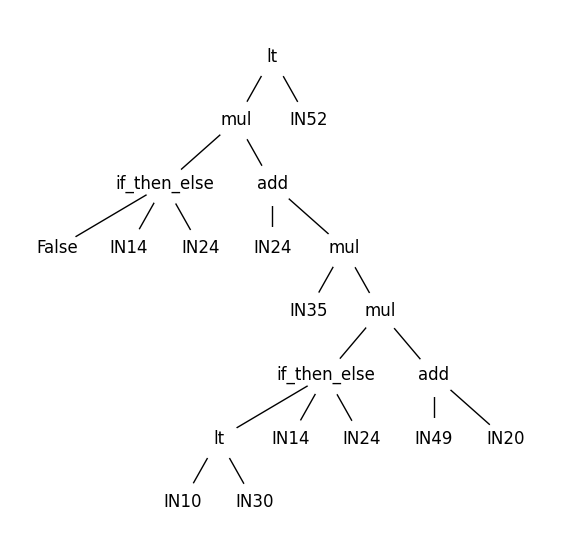

In [25]:
# grafíca grafo
plt.figure(figsize=(7,7))
nx.draw_networkx_nodes(graph, pos, node_size=900, node_color="w")
nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_labels(graph, pos, labels)
plt.axis("off")
plt.show()